In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy.linalg import svd

import mne
from mne.preprocessing import (
    ICA,
    compute_proj_ecg,
    compute_proj_eog,
    create_ecg_epochs,
    create_eog_epochs,
)


def setup_3d_axes():
    ax = plt.axes(projection="3d")
    ax.view_init(azim=-105, elev=20)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 5)
    ax.set_zlim(0, 5)
    return ax

## 1. Load data

In [9]:
# Load EEG data from a BrainVision file
eeg = mne.io.read_raw_brainvision('..\DATA_FOLDER\sub-010002\RSEEG\sub-010002.vhdr', eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)

eeg2 = mne.io.read_raw_brainvision('..\DATA_FOLDER\sub-010003\RSEEG\sub-010003.vhdr', eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)
eeg3 = mne.io.read_raw_brainvision('..\DATA_FOLDER\sub-010100\RSEEG\sub-010100.vhdr', eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)

Extracting parameters from ..\DATA_FOLDER\sub-010002\RSEEG\sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...
Extracting parameters from ..\DATA_FOLDER\sub-010003\RSEEG\sub-010003.vhdr...
Setting channel info structure...
Reading 0 ... 2519849  =      0.000 ...  1007.940 secs...
Extracting parameters from ..\DATA_FOLDER\sub-010100\RSEEG\sub-010100.vhdr...
Setting channel info structure...
Reading 0 ... 2080238  =      0.000 ...   832.095 secs...


C:\Users\enriq\AppData\Local\Temp\ipykernel_25796\1644956334.py:5: RuntimeWarning: Omitted 170 annotation(s) that were outside data range.
  eeg3 = mne.io.read_raw_brainvision('..\DATA_FOLDER\sub-010100\RSEEG\sub-010100.vhdr', eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)


In [10]:
eeg.set_montage('standard_1020')

<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GB, data loaded>

## 2. Info from data

Some links that may help getting started:

https://mne.tools/stable/auto_tutorials/raw/10_raw_overview.html#sphx-glr-auto-tutorials-raw-10-raw-overview-py


In [11]:
eeg.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 61 EEG, 1 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2013-11-11 13:47:40 UTC
 nchan: 62
 projs: []
 sfreq: 2500.0 Hz
>

In [12]:
# Sampling frequency
eeg.info['sfreq']

2500.0

In [13]:
print(eeg.info["description"])

None


In [14]:
# Electrooculography
len(eeg['VEOG'])

2

### 2.1. Time-domain

In [15]:
# Number of time samples that we have in each channel
eeg.n_times

2555000

In [16]:
# Sample times that we have in each channel
len(eeg.times)

2555000

In [17]:
# Channel names and number
print(len(eeg.ch_names))
print(eeg.ch_names)

62
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'VEOG', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']


In [18]:
print("The sample data object has {} time samples and {} channels.".format(eeg.n_times, len(eeg.ch_names)))

The sample data object has 2555000 time samples and 62 channels.


In [19]:
print("The last time sample is at {} seconds.".format(eeg.times[-1]))
print("The first few channel names are {}.".format(", ".join(eeg.ch_names[:3])))

The last time sample is at 1021.9996 seconds.
The first few channel names are Fp1, Fp2, F7.


In [20]:
# Time, sample number, and sample index
print(eeg.time_as_index(20))
print(eeg.time_as_index([20, 30, 40]), "\n")

print(np.diff(eeg.time_as_index([1, 2, 3])))

[50000]
[ 50000  75000 100000] 

[2500 2500]


### 2.2. Selection of data

In [14]:
# Selecting, dropping, and reordering channels (in case we have other types of channels, not only eeg and eog)

eeg_and_eog = eeg.copy().pick(picks=["eeg", "eog"])
print(len(eeg.ch_names), "→", len(eeg_and_eog.ch_names))

raw_temp = eeg.copy()
print("Number of channels in raw_temp:")
print(len(raw_temp.ch_names), end=" → drop two → ")
raw_temp.drop_channels(["Pz", "P8"])
print(len(raw_temp.ch_names), end=" → pick three → ")
raw_temp.pick(["Fp1", "Fp2", "F7"])
print(len(raw_temp.ch_names))

62 → 62
Number of channels in raw_temp:
62 → drop two → 60 → pick three → 3


In [15]:
# Selection in the time domain

raw_selection1 = eeg.copy().crop(tmin=30, tmax=30.1)  # 0.1 seconds
raw_selection2 = eeg.copy().crop(tmin=40, tmax=41.1)  # 1.1 seconds
raw_selection3 = eeg.copy().crop(tmin=50, tmax=51.3)  # 1.3 seconds
raw_selection1.append([raw_selection2, raw_selection3])  # 2.5 seconds total
print(raw_selection1.times.min(), raw_selection1.times.max())

0.0 2.5008


### 2.3. Channels and extraction of data

(array([[0.0002273, 0.0002242, 0.0002306, ..., 0.0001671, 0.0001606,
        0.0001642]]), array([11.    , 11.0004, 11.0008, ..., 12.9988, 12.9992, 12.9996]))


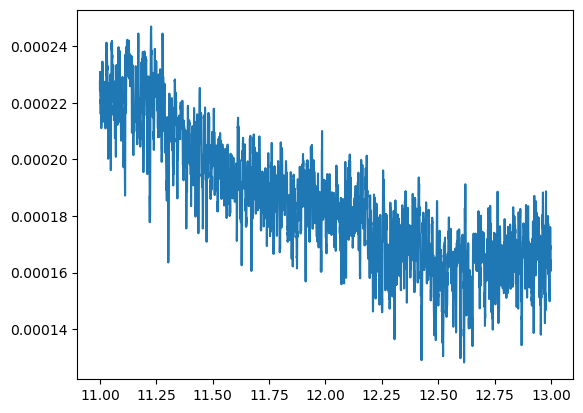

In [16]:
# Extracting data by index
sampling_freq = eeg.info["sfreq"]
start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = eeg[channel_index, start_sample:stop_sample]
print(raw_selection)

# Plotting the extracted data
x = raw_selection[1]
y = raw_selection[0].T
plt.plot(x, y)

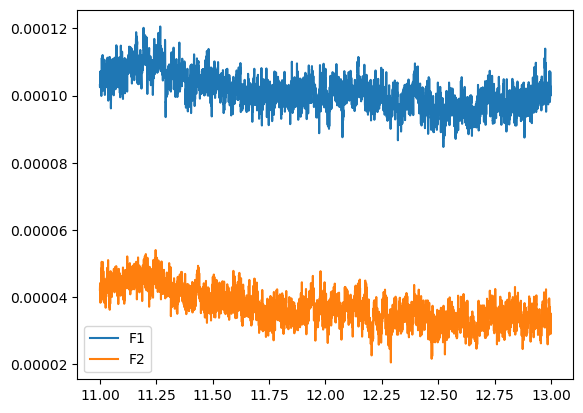

In [17]:
# Extracting channels by name
channel_names = ["F1", "F2"]
two_meg_chans = eeg[channel_names, start_sample:stop_sample]
y_offset = np.array([5e-5, 0])  # just enough to separate the channel traces
x = two_meg_chans[1]
y = two_meg_chans[0].T + y_offset
lines = plt.plot(x, y)
plt.legend(lines, channel_names)

In [18]:
# Extracting channels by type
eeg_channel_indices = mne.pick_types(eeg.info, meg=False, eeg=True)
eeg_data, times = eeg[eeg_channel_indices]
print(eeg_data.shape)

(61, 2555000)


### 2.4. Data inside eegs

In [21]:
# Store the eeg values
data = eeg._data
#data = eeg.get_data(return_times=True)
print(data.shape)

(62, 2555000)


In [22]:
# Data inside eegs
first_channel_data = eeg.get_data(picks=0)
eeg_and_eog_data = eeg.get_data(picks=["eeg", "eog"])
two_meg_chans_data = eeg.get_data(picks=["F1", "F2"], start=1000, stop=2000)

print(first_channel_data.shape)
print(eeg_and_eog_data.shape)
print(two_meg_chans_data.shape)

(1, 2555000)
(62, 2555000)
(2, 1000)


## 3. Events

Some links that may help getting started:

https://mne.tools/stable/auto_tutorials/raw/20_event_arrays.html#sphx-glr-auto-tutorials-raw-20-event-arrays-py

In [23]:
events, event_dict = mne.events_from_annotations(eeg)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']


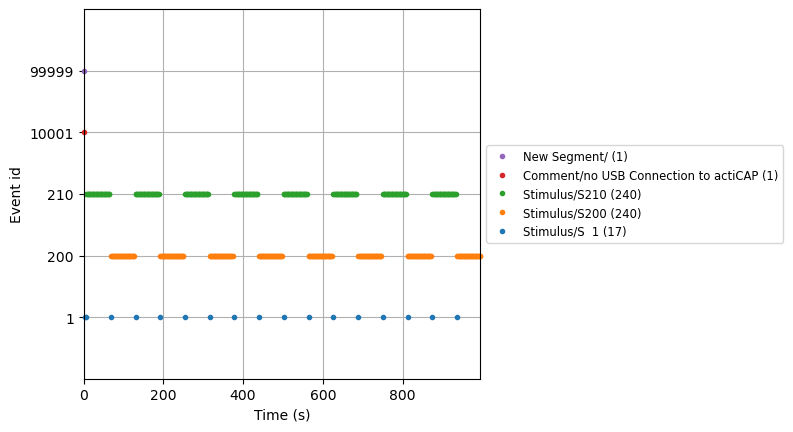

In [22]:
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=eeg.info["sfreq"], first_samp=eeg.first_samp
)

## 4. Plot the EEG

### 4.1. 'Interactive' plot

Using matplotlib as 2D backend.


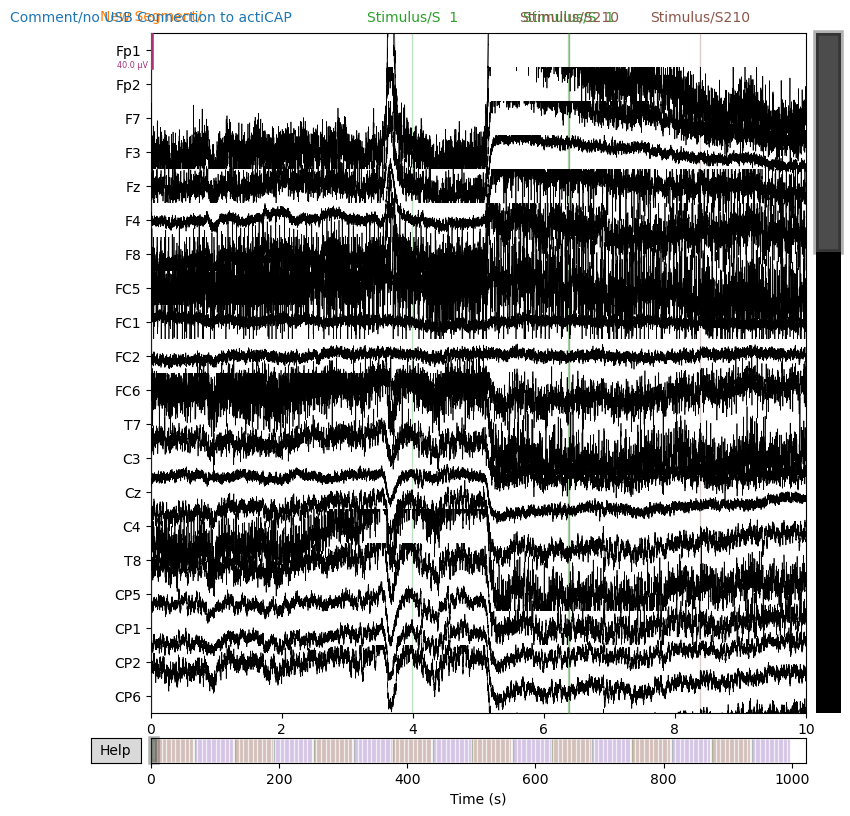

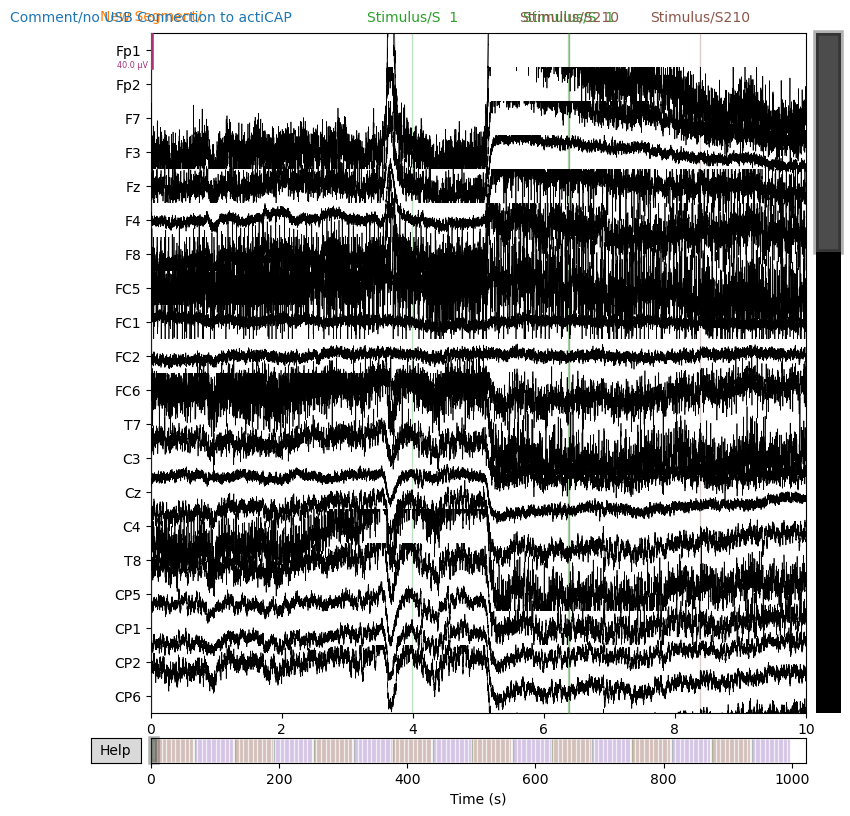

In [23]:
eeg.plot()

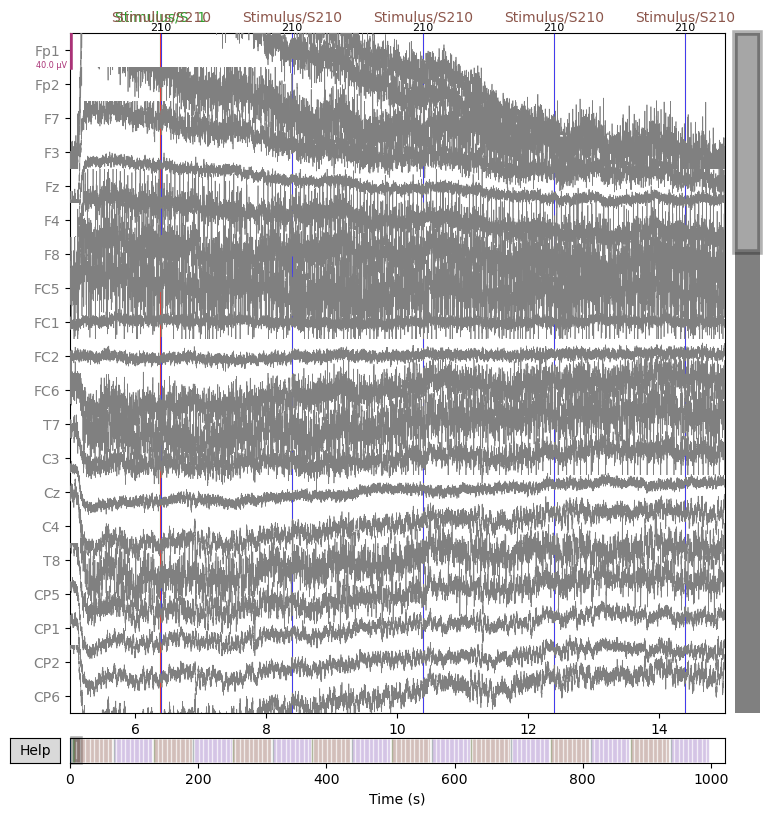

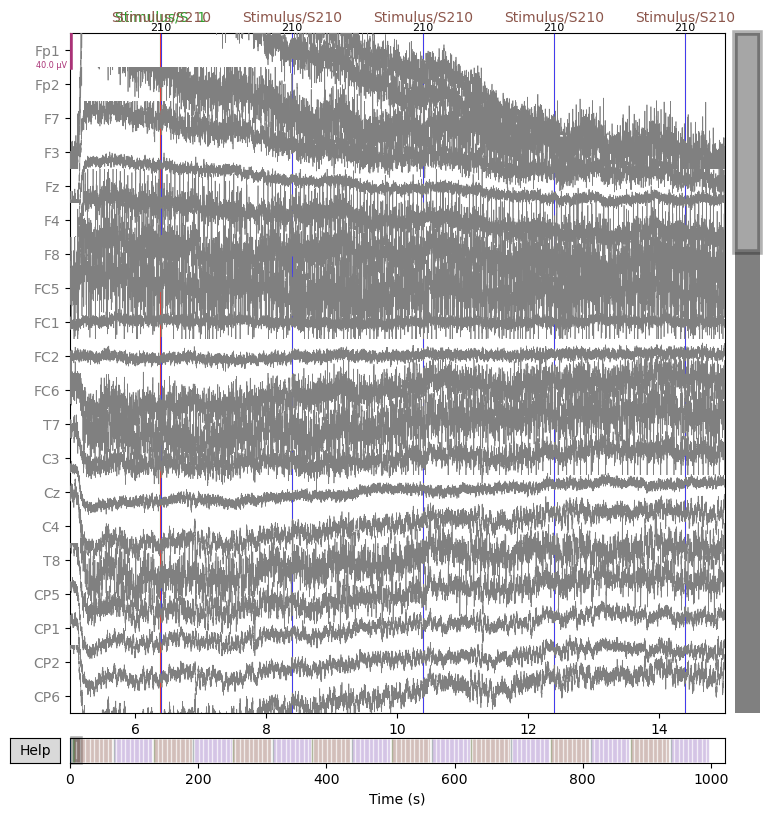

In [24]:
eeg.plot(
    events=events,
    start=5,
    duration=10,
    color="gray",
    event_color={1: "r", 200: "g", 210: "b", 99999: "m", 10001: "k"}
)

### 4.2. Plotting spectral density of continuous data

Effective window size : 0.819 (s)


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


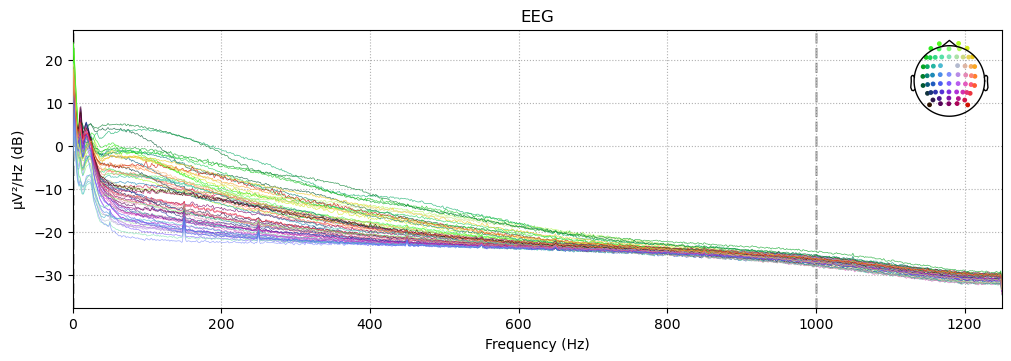

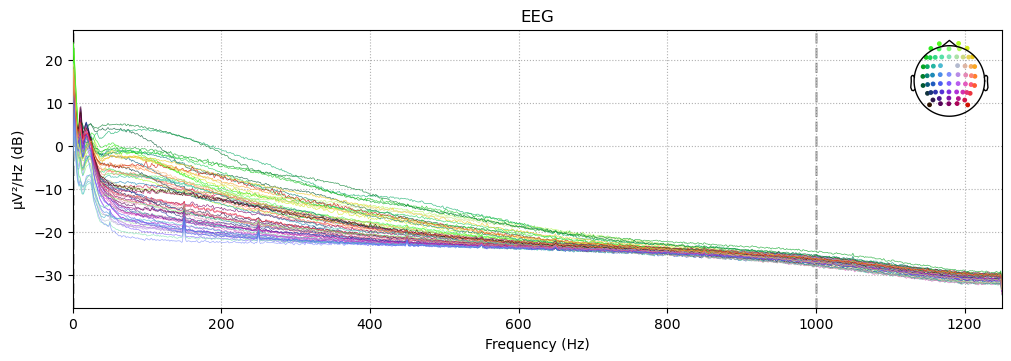

In [25]:
spectrum = eeg.compute_psd()
spectrum.plot(picks="eeg", exclude="bads")

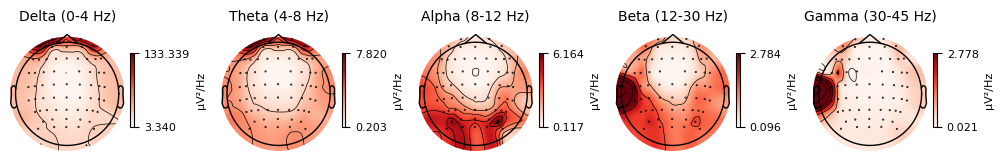

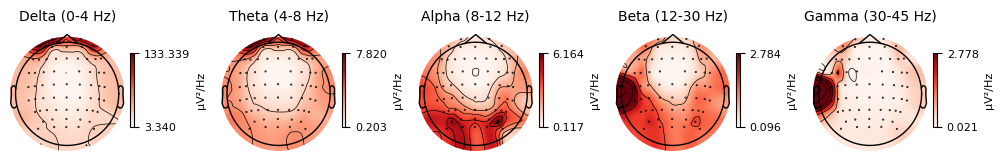

In [26]:
spectrum.plot_topomap()

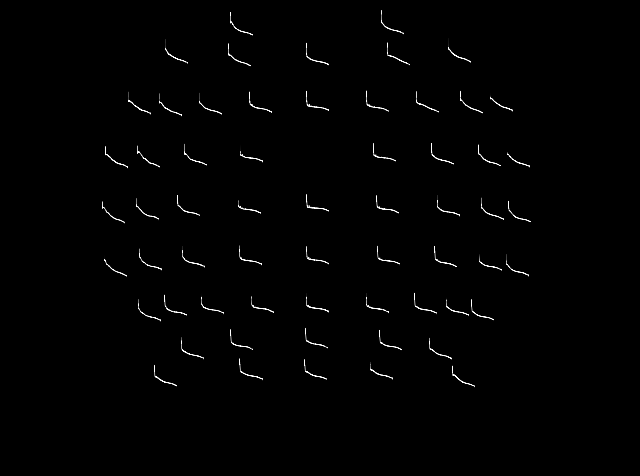

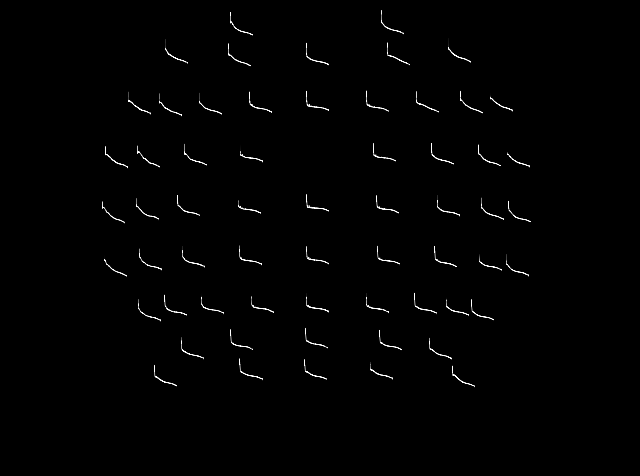

In [27]:
spectrum.plot_topo()

### 4.3. Plotting sensor locations from Raw objects

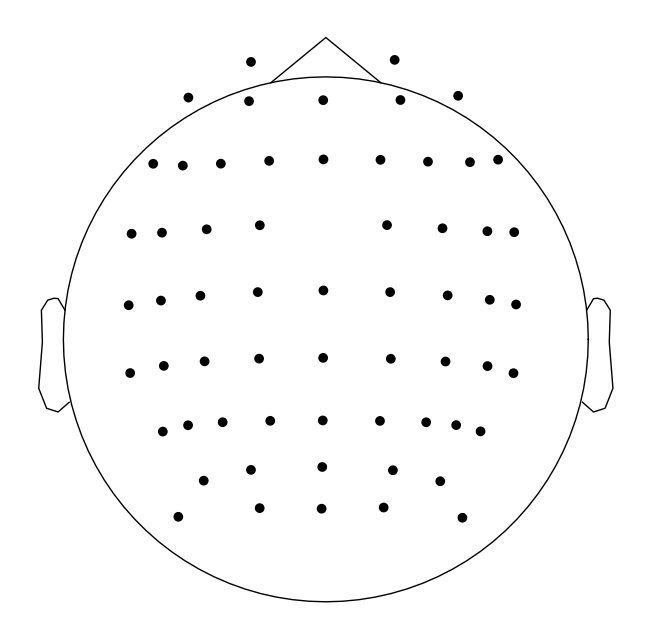

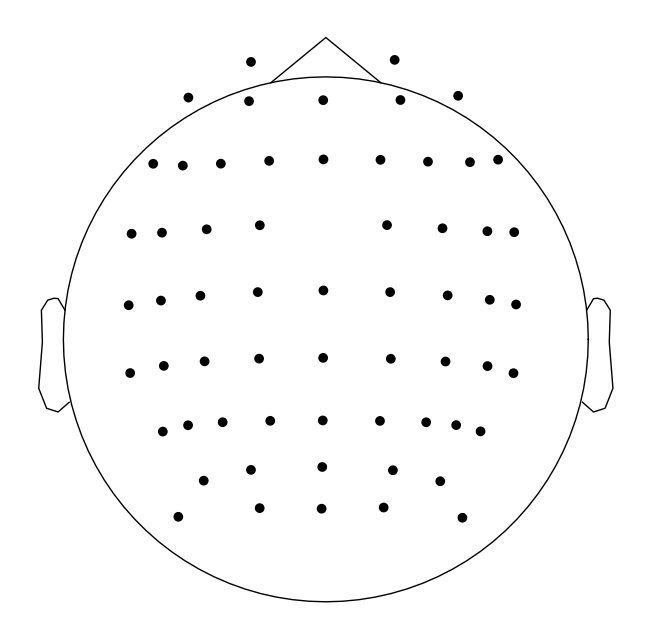

In [28]:
eeg.plot_sensors(ch_type="eeg")

## 5. Preprocessing

Some links that may help getting started:

https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#sphx-glr-auto-tutorials-preprocessing-30-filtering-resampling-py

### 5.1. Filtering (1-20 Hz)

In [24]:
eeg_filtered = eeg.copy().filter(l_freq=1, h_freq=20, fir_design="firwin", verbose=False)

Using matplotlib as 2D backend.


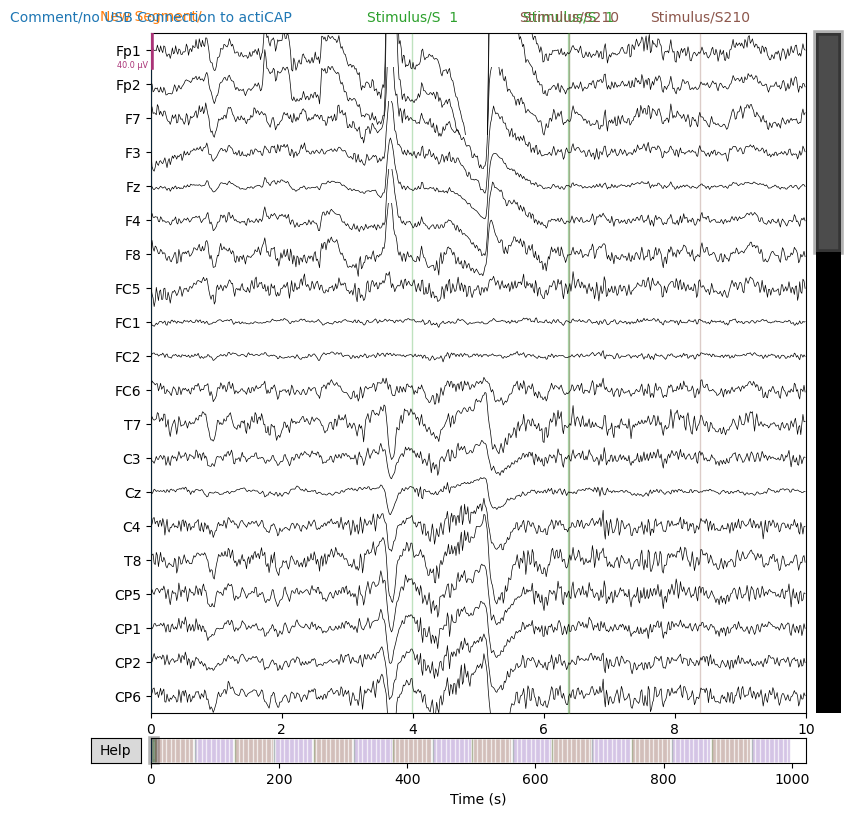

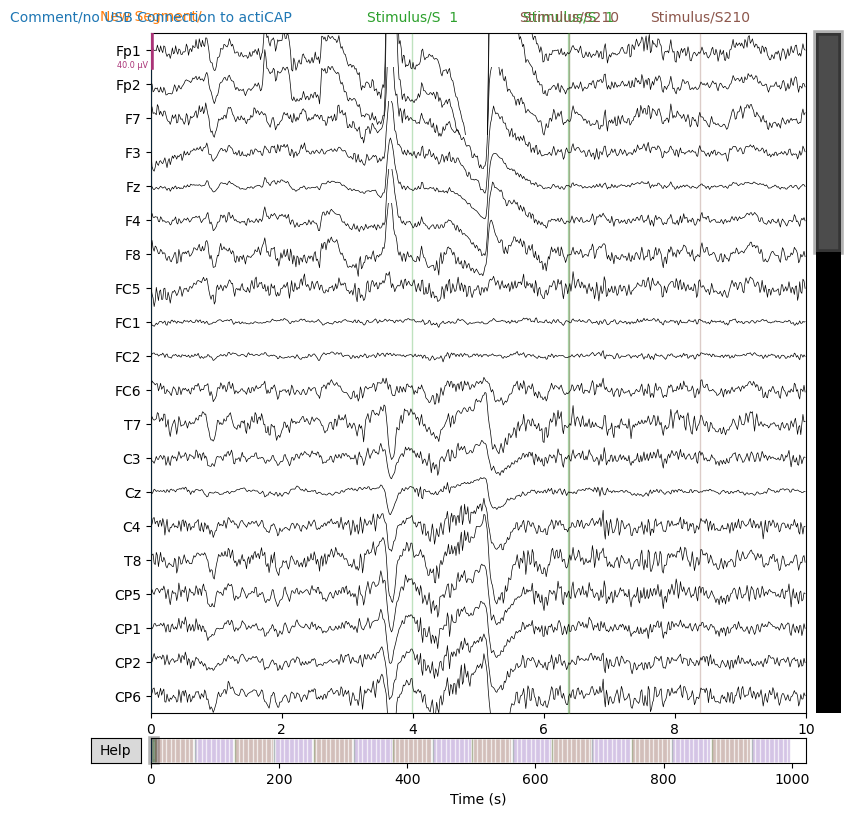

In [25]:
eeg_filtered.plot()

#### 5.1.1. Filter parameters

In [31]:
filter_params = mne.filter.create_filter(
    eeg.get_data(), eeg.info["sfreq"], l_freq=1, h_freq=20
)

Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8251 samples (3.300 s)



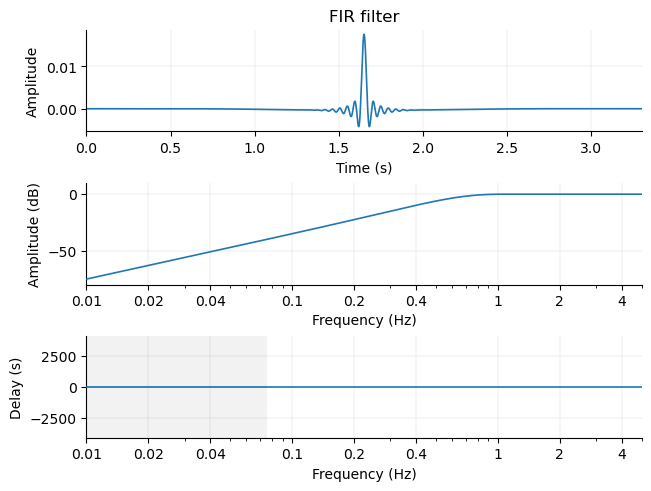

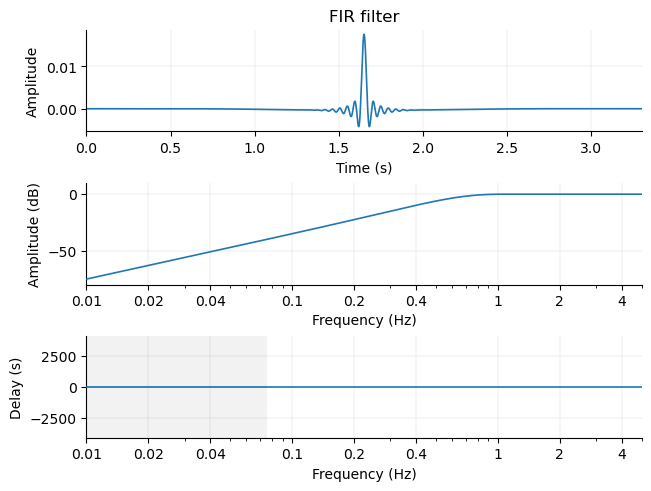

In [32]:
mne.viz.plot_filter(filter_params, eeg.info["sfreq"], flim=(0.01, 5))

#### 5.1.2 Power line noise

Effective window size : 0.819 (s)


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


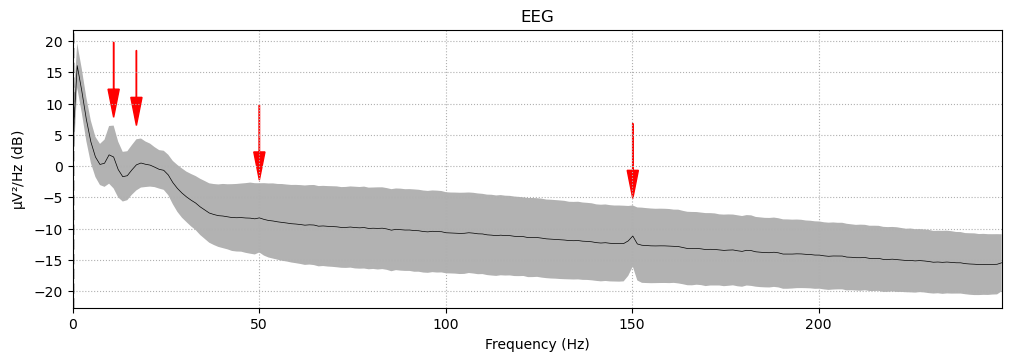

In [33]:
def add_arrows(axes):
    # add some arrows at 60 Hz and its harmonics
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (10, 17, 50, 150):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )


fig = eeg.compute_psd(fmax=250).plot(average=True, picks="data", exclude="bads")
add_arrows(fig.axes[:2])

Effective window size : 0.819 (s)
Effective window size : 0.819 (s)


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


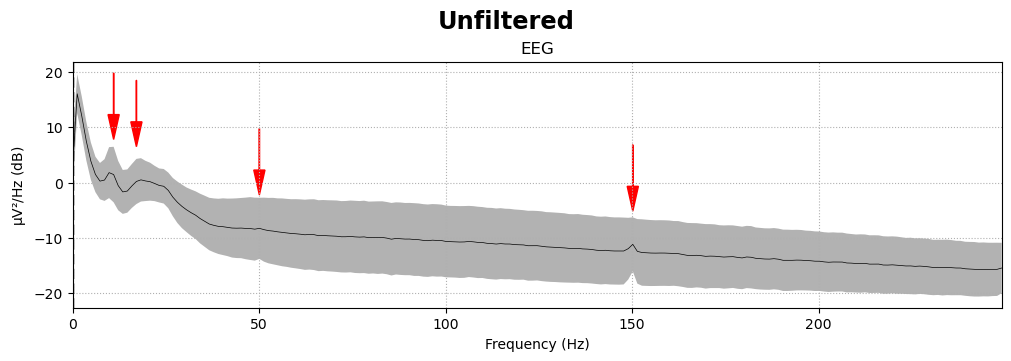

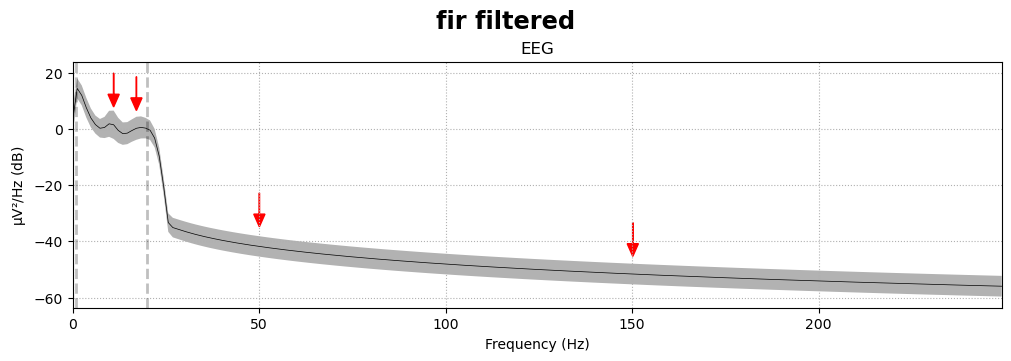

In [34]:
meg_picks = mne.pick_types(eeg.info, meg=True)
freqs = (60, 120, 180, 240)

for title, data in zip(["Un", "fir "], [eeg, eeg_filtered]):
    fig = data.compute_psd(fmax=250).plot(average=True, picks="data", exclude="bads")
    fig.suptitle("{}filtered".format(title), size="xx-large", weight="bold")
    add_arrows(fig.axes[:2])

### 5.1.3 Resampling

In [26]:
eeg_downsampled = eeg_filtered.copy().resample(sfreq=250)

Effective window size : 0.819 (s)
Effective window size : 10.240 (s)


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


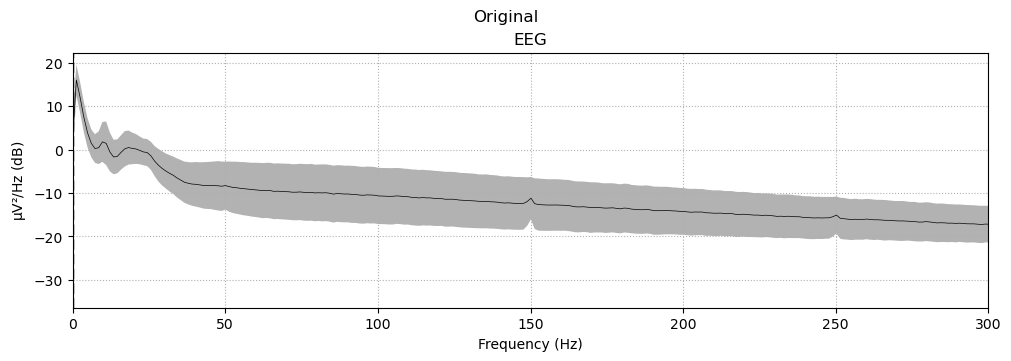

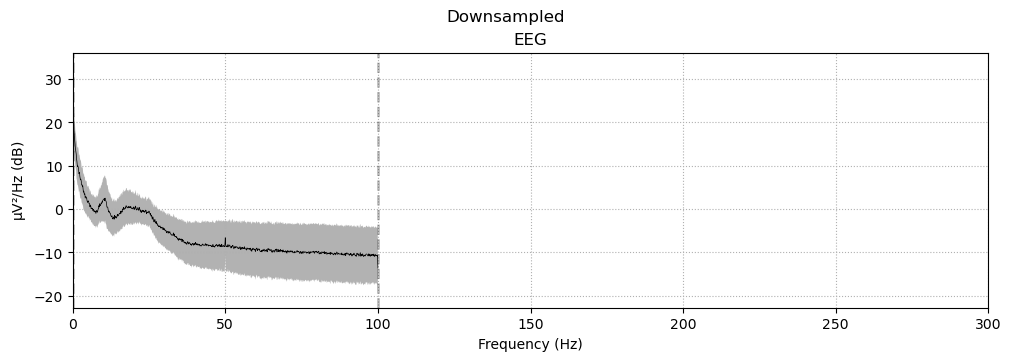

In [35]:
for data, title in zip([eeg, raw_downsampled], ["Original", "Downsampled"]):
    fig = data.compute_psd().plot(average=True, picks="data", exclude="bads")
    fig.suptitle(title)
    plt.setp(fig.axes, xlim=(0, 300))

### 5.1.4 Best practices

In [36]:
current_sfreq = eeg.info["sfreq"]
desired_sfreq = 90  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.0

raw_filtered = eeg.copy().filter(l_freq=None, h_freq=lowpass_freq)
#epochs = mne.Epochs(raw_filtered, events, decim=decim)
epochs = mne.Epochs(
    eeg,
    events=events,
    event_id=[event_dict["Stimulus/S200"], event_dict["Stimulus/S210"], event_dict["Stimulus/S  1"]],
    tmin=-1,
    tmax=65,
    decim=decim,
    baseline=None,
    verbose=False,
)

print(
    "desired sampling frequency was {} Hz; decim factor of {} yielded an "
    "actual sampling frequency of {} Hz.".format(
        desired_sfreq, decim, epochs.info["sfreq"]
    )
)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 29.76 Hz
- Upper transition bandwidth: 7.44 Hz (-6 dB cutoff frequency: 33.48 Hz)
- Filter length: 1109 samples (0.444 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    4.2s finished


desired sampling frequency was 90 Hz; decim factor of 28 yielded an actual sampling frequency of 89.28571428571429 Hz.


C:\Users\enriq\AppData\Local\Temp\ipykernel_17696\1735229690.py:9: RuntimeWarning: The measurement information indicates a low-pass frequency of 1000.0 Hz. The decim=28 parameter will result in a sampling frequency of 89.28571428571429 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


### 5.2. Ocular artifacts

Some links that may help getting started:

https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py

Also, some links to look:

https://mne.tools/stable/auto_tutorials/preprocessing/35_artifact_correction_regression.html#sphx-glr-auto-tutorials-preprocessing-35-artifact-correction-regression-py

Using EOG channel: VEOG
EOG channel index for this subject is: [16]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 20.25 Hz)
- Filter length: 25000 samples (10.000 s)

Now detecting blinks and generating corresponding events


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Found 62 significant peaks
Number of EOG events detected: 62
Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 62 events and 2501 original time points ...
0 bad epochs dropped
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


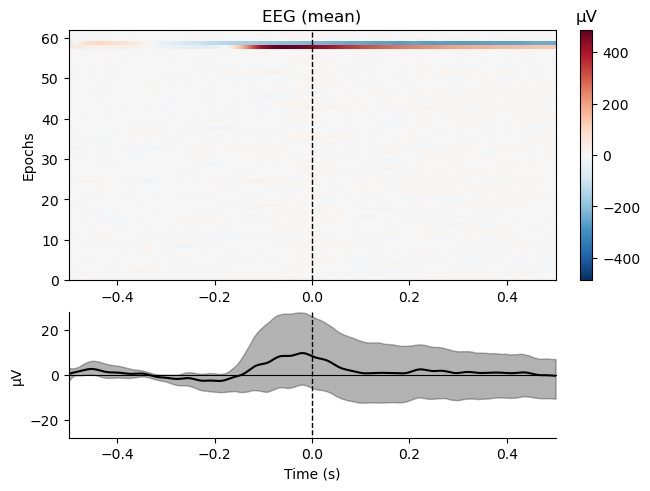

No projector specified for this dataset. Please consider the method self.add_proj.


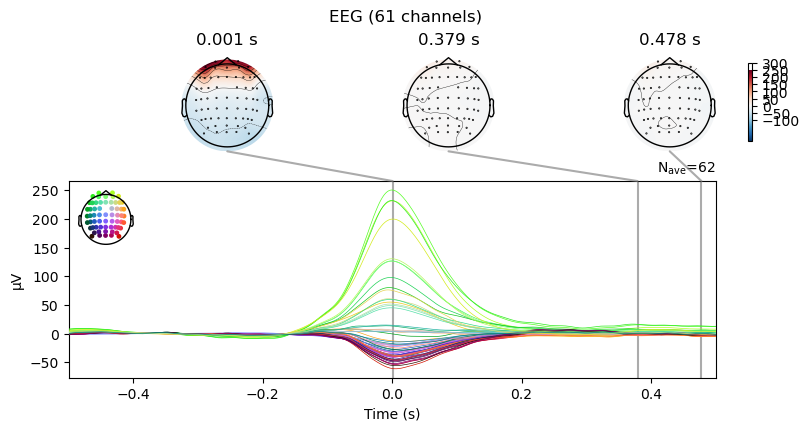

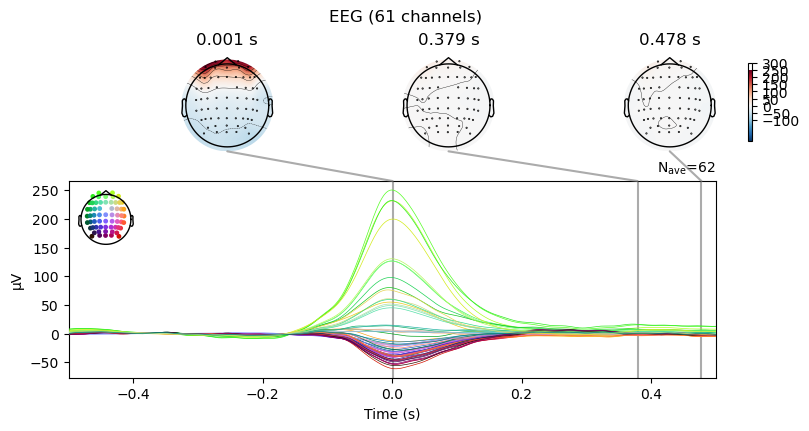

In [27]:
# PASO 1: Calculamos los epochs según los artefactos oculares
eog_epochs = create_eog_epochs(eeg_filtered, ch_name='VEOG', l_freq=1, h_freq=20, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

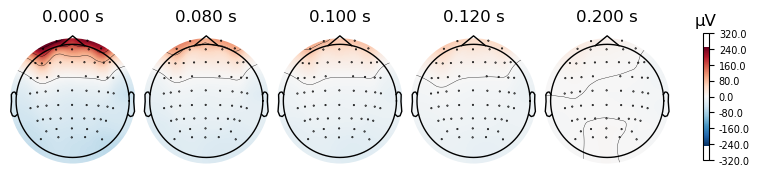

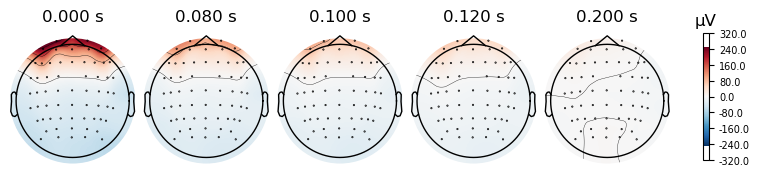

In [28]:
eog_epochs.average().plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

In [29]:
# PASO 2: Entrenamos ICA para dividir en componentes
eog_average = eog_epochs.average()
ica = ICA(n_components=7, random_state=20)
ica.fit(eeg_filtered)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 30.1s.


<ICA | raw data decomposition, method: fastica (fit in 13 iterations on 2555000 samples), 7 ICA components (61 PCA components available), channel types: eeg, no sources marked for exclusion>

In [30]:
# Podemos calcular la varianza explicada por todos los componentes
explained_var_ratio = ica.get_explained_variance_ratio(eeg_filtered)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.9517689908926894


In [31]:
# Podemos calcular la varianza explicada por cada componente
for i in range(7):    
    explained_var_ratio = ica.get_explained_variance_ratio(
        eeg_filtered, components=[i], ch_type="eeg"
    )
    # This time, print as percentage.
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(
        f"Fraction of variance in EEG signal explained by component {i}: "
        f"{ratio_percent}%"
    )

Fraction of variance in EEG signal explained by component 0: 60%
Fraction of variance in EEG signal explained by component 1: 7%
Fraction of variance in EEG signal explained by component 2: 6%
Fraction of variance in EEG signal explained by component 3: 7%
Fraction of variance in EEG signal explained by component 4: 7%
Fraction of variance in EEG signal explained by component 5: 5%
Fraction of variance in EEG signal explained by component 6: 3%


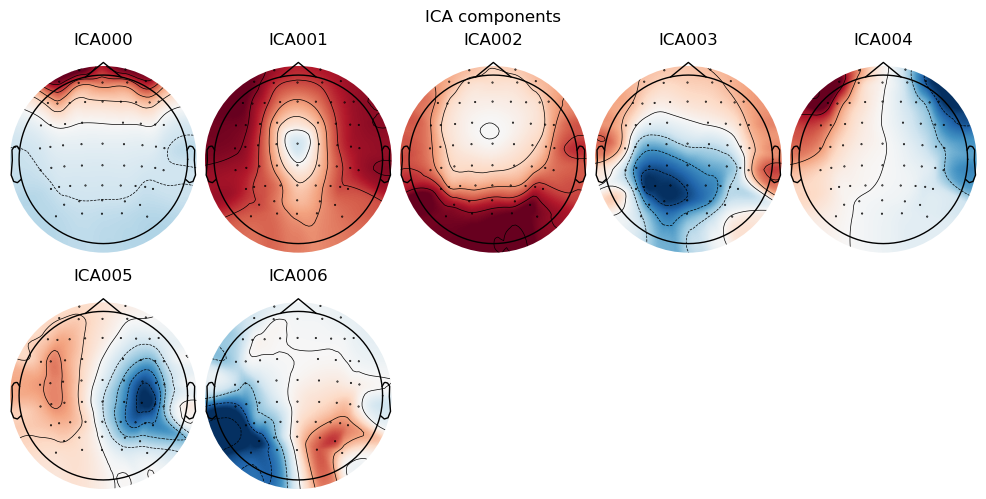

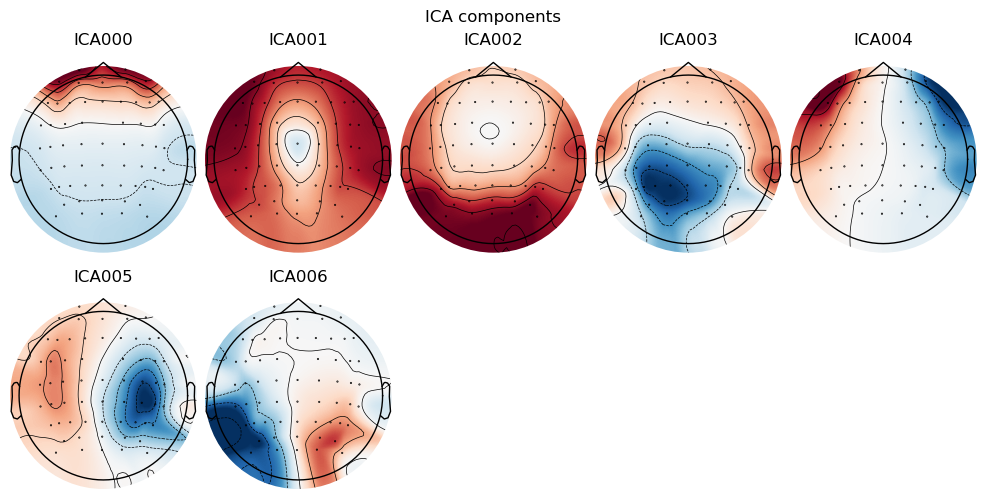

In [69]:
# PASO 3: Ploteamos los componentes
ica.plot_components()

Creating RawArray with float64 data, n_channels=8, n_times=2555000
    Range : 0 ... 2554999 =      0.000 ...  1022.000 secs
Ready.


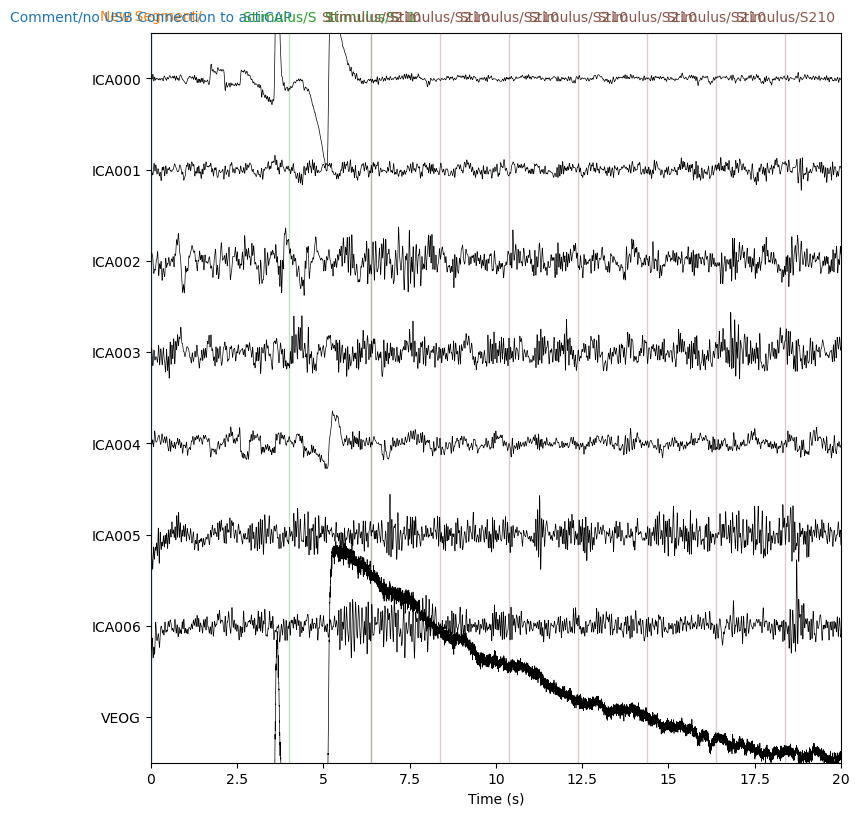

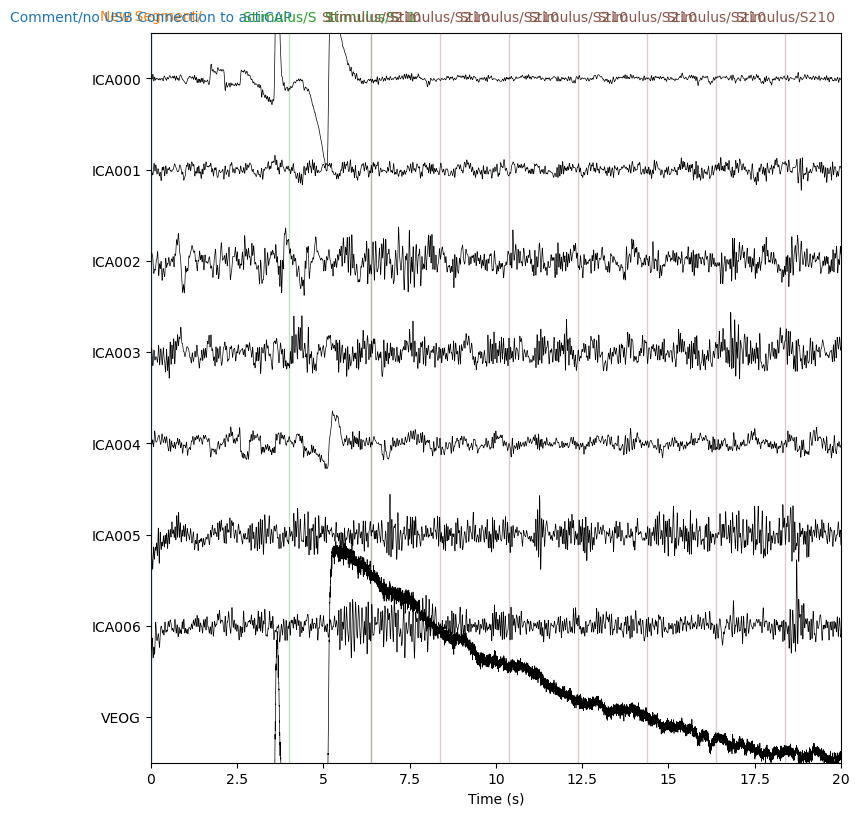

In [70]:
# y las sources
eeg_filtered.load_data()
ica.plot_sources(eeg_filtered, show_scrollbars=False)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


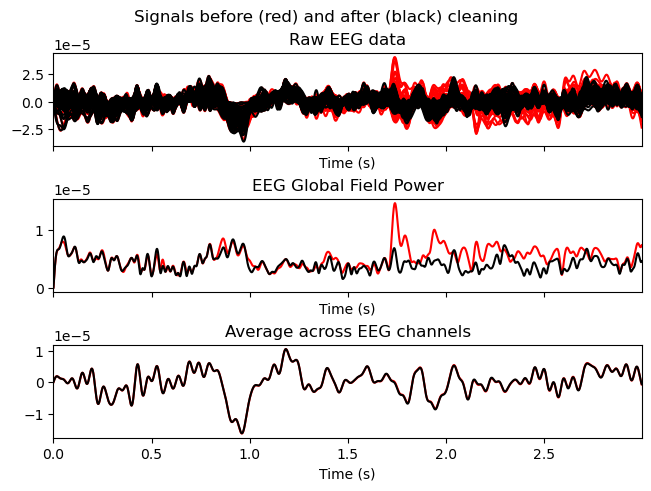

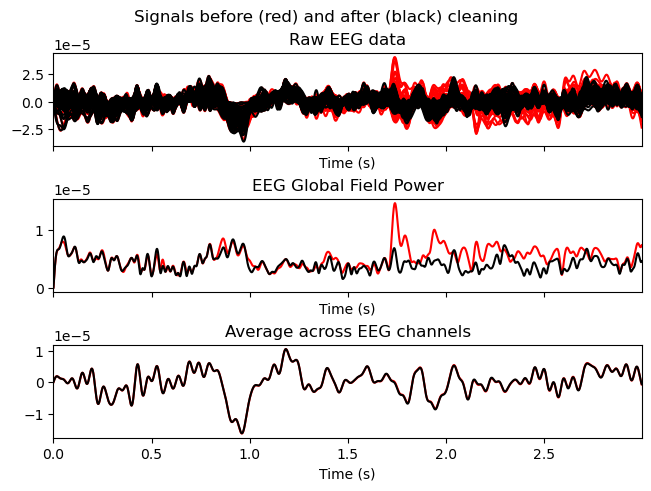

In [71]:
# blinks: plot an overlay of the original signal against the reconstructed signal with the artifactual ICs excluded
ica.plot_overlay(eeg_filtered, exclude=[0], picks="eeg")

In [136]:
# PASO 4: Se calculan aquellos componentes que componen los artefactos oculares
eog_inds, scores = ica.find_bads_eog(eog_epochs, threshold=0.8, l_freq=1, h_freq=20)
print(eog_inds)

Using EOG channel: VEOG
[0]


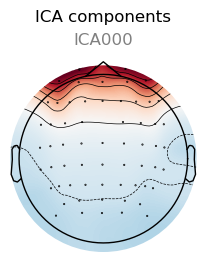

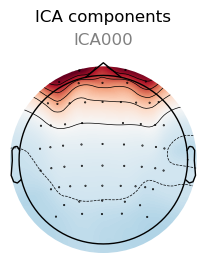

In [82]:
# Se plotean los componenetes
ica.plot_components(picks=eog_inds)

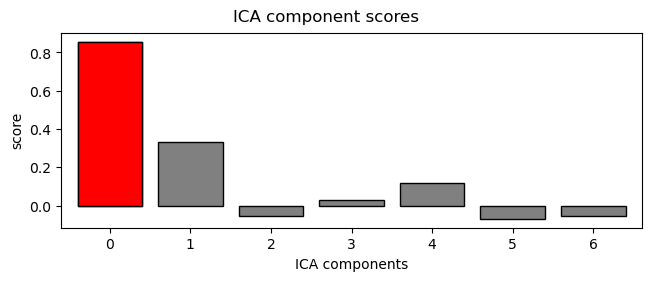

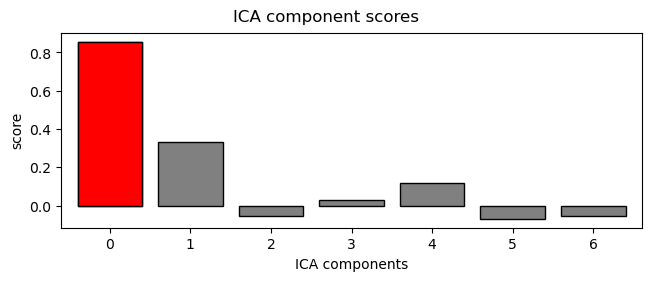

In [83]:
# barplot of ICA component "EOG match" scores
ica.plot_scores(scores)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
511 matching events found
No baseline correction applied
0 projection items activated


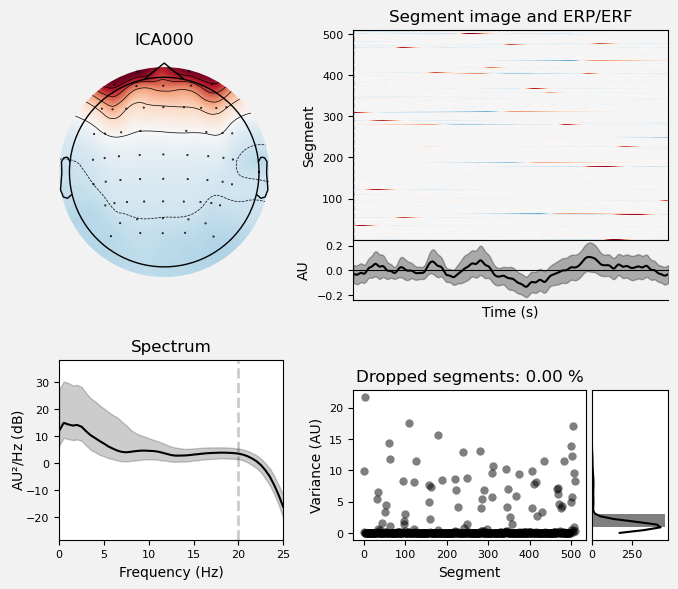

[<Figure size 700x600 with 6 Axes>]

In [84]:
# We can also plot some diagnostics of each IC
ica.plot_properties(eeg_filtered, picks=[0])

Creating RawArray with float64 data, n_channels=8, n_times=2555000
    Range : 0 ... 2554999 =      0.000 ...  1022.000 secs
Ready.


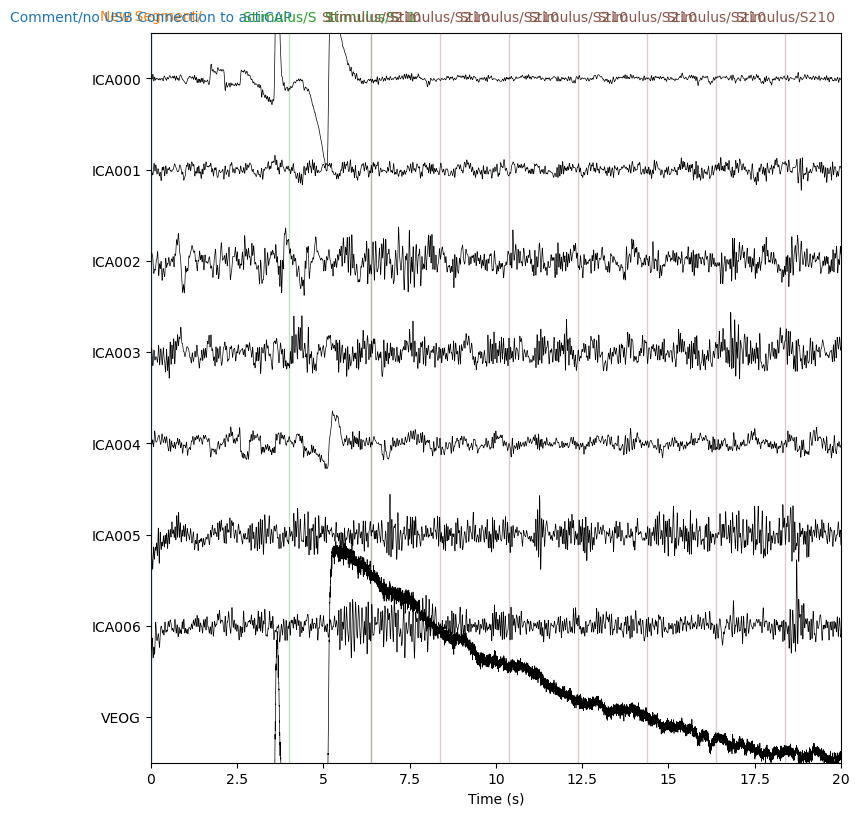

Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


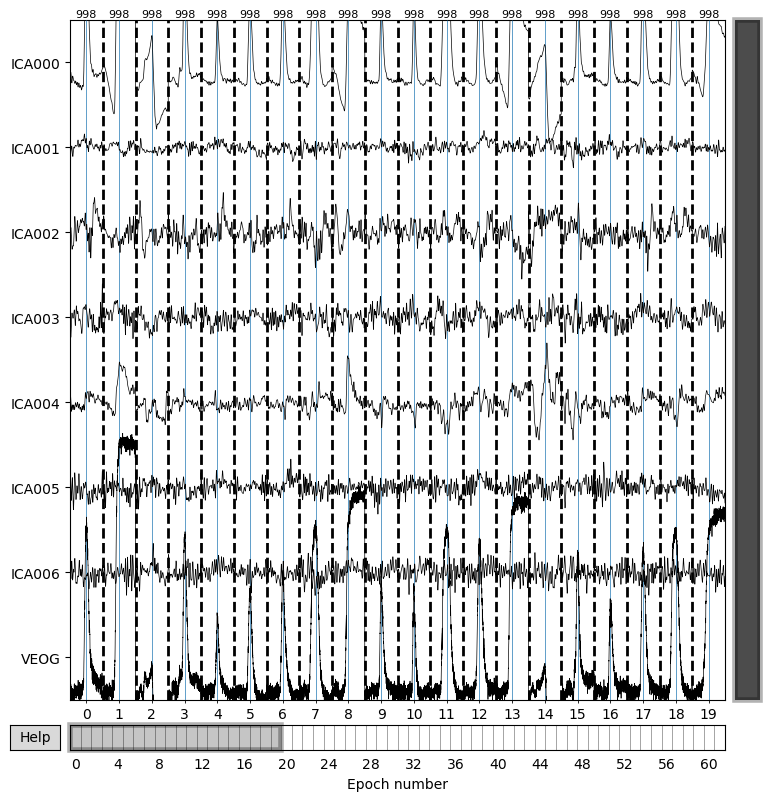

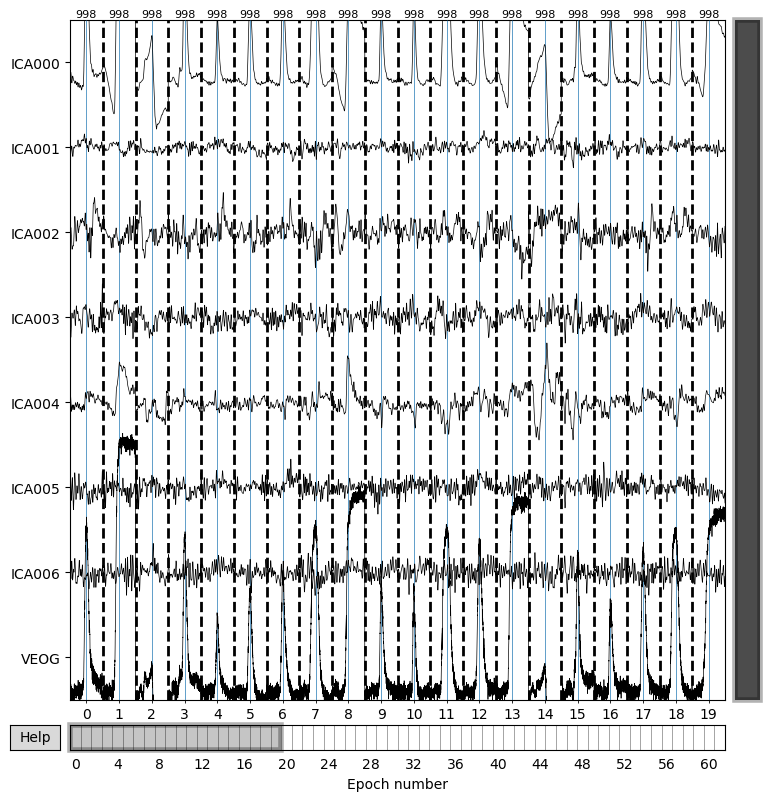

In [77]:
# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(eeg_filtered, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_epochs)

In [78]:
# PASO 5: Remover los componentes relacionados con EOG de los datos crudos
ica.exclude = eog_inds
cleaned_eeg = eeg_filtered.copy()
ica.apply(cleaned_eeg)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


<RawBrainVision | sub-010002.eeg, 62 x 2555000 (1022.0 s), ~1.18 GB, data loaded>

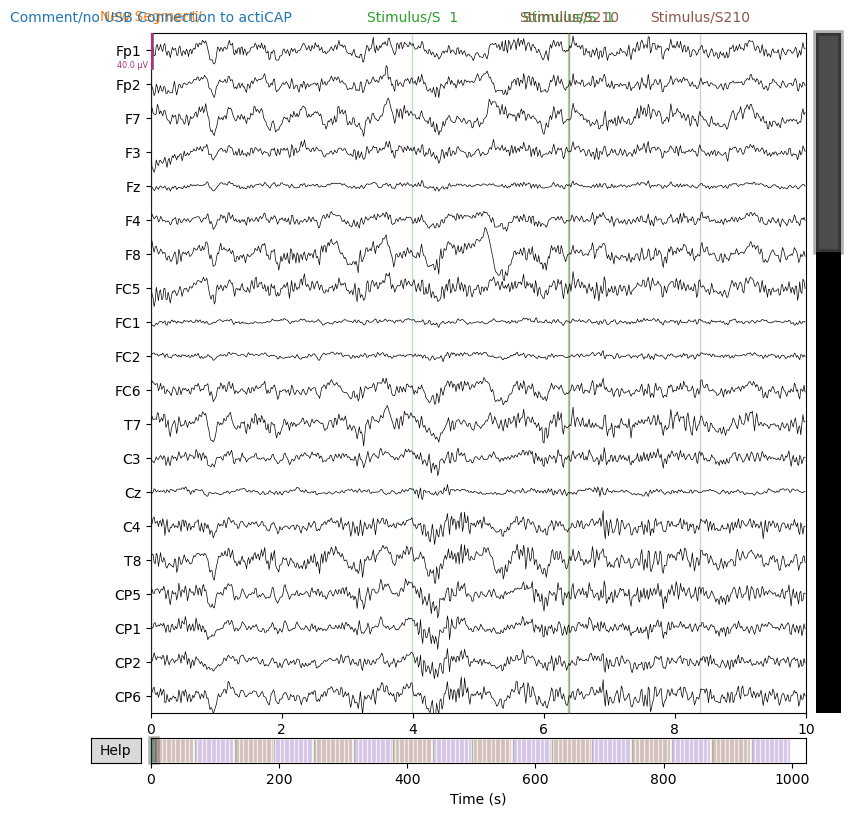

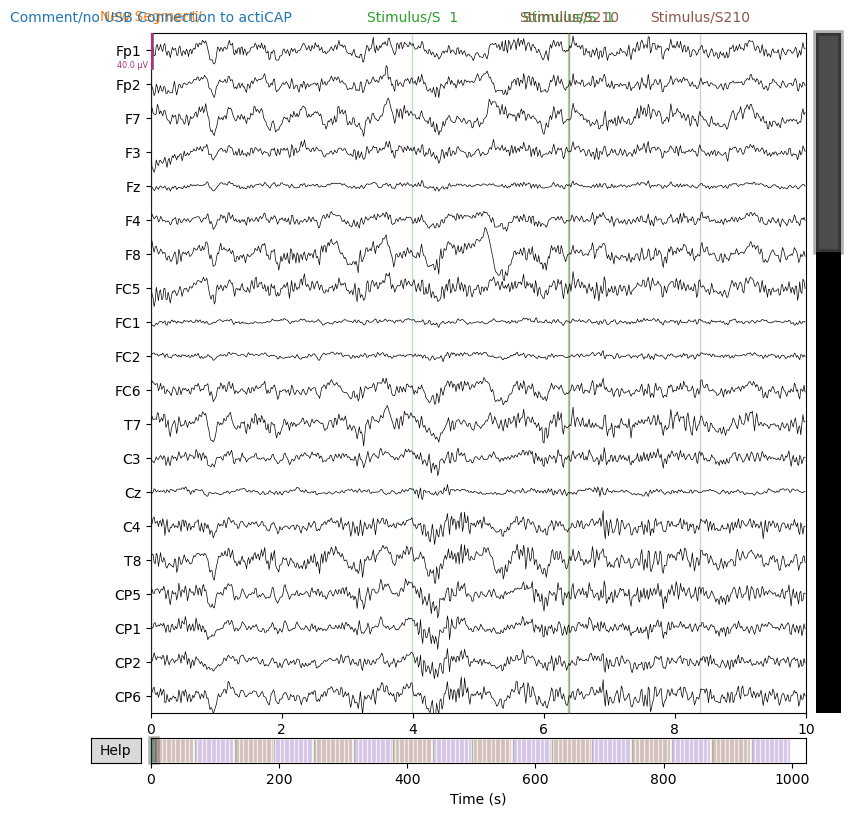

In [79]:
# PASO 6: Visualizar los resultados (opcional)
cleaned_eeg.plot()

## 5.3. Epochs

In [119]:
for e in events:
    print(e)

[    0     0 99999]
[    0     0 10001]
[9979    0    1]
[15938     0     1]
[15962     0   210]
[20962     0   210]
[25962     0   210]
[30962     0   210]
[35962     0   210]
[40962     0   210]
[45962     0   210]
[50962     0   210]
[55962     0   210]
[60962     0   210]
[65963     0   210]
[70963     0   210]
[75963     0   210]
[80963     0   210]
[85963     0   210]
[90963     0   210]
[95963     0   210]
[100963      0    210]
[105963      0    210]
[110963      0    210]
[115963      0    210]
[120963      0    210]
[125964      0    210]
[130964      0    210]
[135964      0    210]
[140964      0    210]
[145964      0    210]
[150964      0    210]
[155964      0    210]
[160964      0    210]
[171846      0      1]
[171871      0    200]
[176871      0    200]
[181871      0    200]
[186872      0    200]
[191872      0    200]
[196872      0    200]
[201872      0    200]
[206872      0    200]
[211872      0    200]
[216872      0    200]
[221872      0    200]
[226872 

In [126]:
epochs = mne.Epochs(
    cleaned_eeg,
    events=events,
    event_id=[event_dict["Stimulus/S200"], event_dict["Stimulus/S210"]], # event_dict["Stimulus/S  1"]
    tmin=0,
    tmax=0,
    baseline=None
)

Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated


In [127]:
df = epochs.to_data_frame()
df.iloc[:33, :10]

Using data from preloaded Raw for 480 events and 1 original time points ...
0 bad epochs dropped


time condition  epoch        Fp1        Fp2         F7        F3  \
0    0.0       210      4   1.991291   0.484426  -2.586491 -0.300223   
1    0.0       210      5   0.506882   3.699687   6.476400  6.721564   
2    0.0       210      6  -2.120115   0.760041  -5.432130 -1.917300   
3    0.0       210      7   0.244766   3.475907   0.191688  2.356963   
4    0.0       210      8   1.175870  -0.017731   0.283908 -0.120579   
5    0.0       210      9  -1.983612   4.008434  -3.006802 -3.693052   
6    0.0       210     10   5.766841   6.870530   5.526035  5.085148   
7    0.0       210     11   5.418105   0.006355   3.677000  3.502908   
8    0.0       210     12  -4.989685  -4.039548  -1.886867 -0.134650   
9    0.0       210     13  -8.317611  -2.442831 -12.837565 -7.369956   
10   0.0       210     14  -5.727109  -2.697435  -5.843592 -1.957668   
11   0.0       210     15 -13.501682 -13.241244 -12.858483 -2.554347   
12   0.0       210     16  -2.209298  -6.107300  -3.930985 -3.136904   
13   0.0       210     17  -1.575531   0.815837   6.483759 -0.506394   
14   0.0       210     18  -4.361992  -0.475444  -6.503204 -1.426456   
15   0.0       210     19  -3.402347  -3.013906   0.361920 -1.929023   
16   0.0       210     20   1.611111   2.618062   0.750978  0.084739   
17   0.0       210     21   2.318806   0.646213   4.685135 -1.216885   
18   0.0       210     22  -7.001894  -6.441778 -12.045043 -4.258971   
19   0.0       210     23  -0.208147  -0.747519   0.906027  0.406203   
20   0.0       210     24  -3.133944  -2.601426   2.784160  2.851819   
21   0.0       210     25   0.698780  -1.229158  -7.247118 -3.976764   
22   0.0       210     26   7.323751   8.813310   5.318631 -1.481189   
23   0.0       210     27  -8.796735  -8.364167  -6.723103 -5.362692   
24   0.0       210     28  -3.387319  -5.567869  -7.202695 -2.841302   
25   0.0       210     29   3.372676   3.451762   4.690896  5.182266   
26   0.0       210     30  -2.924764  -4.833348  -7.620778 -6.298242   
27   0.0       210     31  -0.905059   1.555087  -0.792825  0.587785   
28   0.0       210     32  -7.586603  -6.522793  -6.420891 -2.954515   
29   0.0       210     33  -7.835784  -5.660339  -6.778395  1.018401   
30   0.0       200     35   2.128774   4.125250   3.471131  6.480847   
31   0.0       200     36   4.136648   2.924389  -0.517377 -0.568398   
32   0.0       200     37  -2.455186  -7.992530  -6.202977 -3.055702   

          Fz        F4         F8  
0   1.393347 -1.243284  -0.002060  
1   1.091326  0.480559  -0.252433  
2  -0.649779 -3.594696  -2.893736  
3   1.048921  4.192225   3.187847  
4  -2.149025 -1.920618   0.189872  
5  -1.268020 -0.431673   3.081568  
6   2.724508  4.689926   7.152483  
7   3.242704  0.054247   2.037944  
8   0.472614 -1.181473  -7.004868  
9  -3.411407  0.543404   0.592470  
10 -0.755406 -1.794272  -2.624550  
11 -2.566436 -4.509933 -14.402698  
12 -0.154029  0.484222  -0.335172  
13  0.685636 -1.741120  -0.338766  
14 -1.231537  2.363900  -1.971947  
15 -0.682207 -0.220167  -1.267769  
16  1.204424  6.080958   4.600995  
17 -1.612024 -2.578392  -2.389465  
18 -1.678228 -5.056013  -8.889622  
19  1.316460  2.452909  -0.277977  
20  0.843021 -1.498187  -8.164560  
21 -0.304291  1.720738   3.030316  
22  2.150749  6.329164  11.694614  
23 -2.613281 -4.241909  -7.537233  
24 -1.795945  0.752930  -1.089593  
25  0.688065  0.042070   0.813082  
26 -3.464214 -3.270713  -4.278847  
27 -0.309375 -0.193197  -1.245260  
28 -3.985533 -6.169162  -8.284725  
29 -0.176000 -2.383184  -9.053653  
30  1.783695 -1.680075  -5.620657  
31  0.620454  2.370853   3.954347  
32 -2.361987 -6.597704 -13.061926

In [121]:
epochs

<Epochs |  497 events (good & bad), 0 – 0 s, baseline off, ~78 kB, data not loaded,
 '200': 240
 '210': 240
 '1': 17>

In [117]:
print(epochs['200'][0:3].get_data())

Using data from preloaded Raw for 3 events and 1 original time points ...
0 bad epochs dropped
[[[ 2.12877385e-06]
  [ 4.12525036e-06]
  [ 3.47113055e-06]
  [ 6.48084734e-06]
  [ 1.78369536e-06]
  [-1.68007491e-06]
  [-5.62065739e-06]
  [ 1.03108461e-05]
  [ 3.99381568e-06]
  [-2.55444898e-06]
  [-4.83423145e-06]
  [ 4.68336224e-06]
  [ 7.12012559e-06]
  [ 4.57300845e-08]
  [-1.00681079e-05]
  [-5.83088807e-06]
  [-3.64400000e-04]
  [ 5.13738331e-06]
  [ 3.01494048e-06]
  [-5.08530503e-06]
  [-7.86738097e-06]
  [ 2.90179272e-06]
  [-1.61177807e-06]
  [ 4.26324958e-06]
  [-1.09428855e-06]
  [-7.58064953e-06]
  [-7.66706076e-06]
  [-6.46089917e-06]
  [-3.75713280e-06]
  [-6.21883714e-06]
  [-6.10218799e-06]
  [-7.50898560e-06]
  [-5.50564286e-07]
  [ 6.07507307e-06]
  [-2.04029026e-07]
  [-1.47861704e-06]
  [ 7.46995153e-06]
  [ 4.26651504e-06]
  [-2.67494917e-07]
  [-3.07683031e-06]
  [ 1.10775858e-06]
  [ 7.50479857e-06]
  [-5.37387058e-06]
  [-4.47104050e-06]
  [ 6.63702562e-06]
  [ 3

In [ ]:
# STEP 6: Store all the segments in one list IN ORDER (for the microstates)

segments = []

for i in range(len(segments_ce)):
    segments.append(segments_ce[i])
    segments.append(segments_oe[i])

## 6. Division of closed and open eyes

In [141]:
# STEP 2: Read events from the marker file
events, event_dict = mne.events_from_annotations(eeg)

for i, item in enumerate(events):
    print(i, item)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']
0 [    0     0 99999]
1 [    0     0 10001]
2 [9979    0    1]
3 [15938     0     1]
4 [15962     0   210]
5 [20962     0   210]
6 [25962     0   210]
7 [30962     0   210]
8 [35962     0   210]
9 [40962     0   210]
10 [45962     0   210]
11 [50962     0   210]
12 [55962     0   210]
13 [60962     0   210]
14 [65963     0   210]
15 [70963     0   210]
16 [75963     0   210]
17 [80963     0   210]
18 [85963     0   210]
19 [90963     0   210]
20 [95963     0   210]
21 [100963      0    210]
22 [105963      0    210]
23 [110963      0    210]
24 [115963      0    210]
25 [120963      0    210]
26 [125964      0    210]
27 [130964      0    210]
28 [135964      0    210]
29 [140964      0    210]
30 [145964      0    210]
31 [150964      0    210]
32 [155964      0    210]
33 [160964      0    210]
34 [171846      0      1]
35 [171871      0    200]
3

In [142]:
# STEP 3: Create a dictionary with important information (star and end time, start and end samples, total time of event...)

sf = eeg.info['sfreq']

d = {}

c1 = 0
c2 = 0
c3 = 0

list_events = []

for i, item in enumerate(events):
    #print('Event', i)
    
    if i != 0 and item[2] != events[i-1][2]:
        #print('Cambio:', item[2], events[i-1][2])
        
        prev_event = events[i-1][2]
        if prev_event == 99999 or prev_event == 10001:
            pass
        
        elif prev_event == 1:
            d['Dc' + str(c1 + 1)] = {
                #'events': list_events,
                'start_sample': start_time,
                'end_sample': item[0],
                'start_time': start_time / sf,
                'end_time': item[0] / sf,  # Tiempo de end es el tiempo actual
                'time': (item[0] - start_time) / sf
            }
            c1 += 1
            
        elif prev_event == 200:
            d['Oe' + str(c2 + 1)] = {
                #'events': list_events,
                'start_sample': start_time,
                'end_sample': item[0],
                'start_time': start_time / sf,
                'end_time': item[0] / sf,  # Tiempo de end es el tiempo actual
                'time': (item[0] - start_time) / sf
            }
            c2 += 1
            
        elif prev_event == 210:
            d['Ce' + str(c3 + 1)] = {
                #'events': list_events,
                'start_sample': start_time,
                'end_sample': item[0],
                'start_time': start_time / sf,
                'end_time': item[0] / sf,  # Tiempo de end es el tiempo actual
                'time': (item[0] - start_time) / sf
            }
            c3 += 1
        
        # Reiniciar la lista de eventos y establecer el tiempo de inicio para el nuevo evento
        list_events = []
        start_time = item[0]
    
    # Añadir evento a la lista de eventos
    list_events.append(item)

# Guardar los datos del último evento
last_event = events[-1][2]
if last_event == 99999 or last_event == 10001:
    pass
elif last_event == 1:
    d['Dc' + str(c1 + 1)] = {
        #'events': list_events,
        'start_sample': start_time,
        'end_sample': item[0],
        'start_time': start_time / sf,
        'end_time': events[-1][0] / sf,  # Tiempo de end es el tiempo del último evento
        'time': (events[-1][0] - start_time) / sf
    }
elif last_event == 200:
    d['Oe' + str(c2 + 1)] = {
        #'events': list_events,
        'start_sample': start_time,
        'end_sample': item[0],
        'start_time': start_time / sf,
        'end_time': events[-1][0] / sf,  # Tiempo de end es el tiempo del último evento
        'time': (events[-1][0] - start_time) / sf
    }
elif last_event == 210:
    d['Ce' + str(c3 + 1)] = {
        #'events': list_events,
        'start_sample': start_time,
        'end_sample': item[0],
        'start_time': start_time / sf,
        'end_time': events[-1][0] / sf,  # Tiempo de end es el tiempo del último evento
        'time': (events[-1][0] - start_time) / sf
    }

# Print the dictionary
#for i, (k, v) in enumerate(d.items()):
#    print('\n')
#    print(k,v)

In [143]:
# STEP 4: Create lists with the start and end times as well as with start samples.

start_times_ce = []
start_times_oe = []
start_samples_ce = []
start_samples_oe = []
end_samples_ce = []
end_samples_oe = []

for key, value in d.items():
    if key.startswith('Ce'):
        start_times_ce.append(value['start_time'])
    elif key.startswith('Oe'):
        start_times_oe.append(value['start_time'])
#Ahora para obtener las muestras:
for key, value in d.items():
    if key.startswith('Ce'):
        start_samples_ce.append(value['start_sample'])
    elif key.startswith('Oe'):
        start_samples_oe.append(value['start_sample'])
for key, value in d.items():
    if key.startswith('Ce'):
        end_samples_ce.append(value['end_sample'])
    elif key.startswith('Oe'):
        end_samples_oe.append(value['end_sample'])
 
print("Start times de eventos EYES CLOSED:", start_times_ce)
print("Start times de eventos EYES OPENED:", start_times_oe)
print("-------------------------------------")
print("Start samples de eventos EYES CLOSED:", start_samples_ce)
print("Start samples de eventos EYES OPENED:", start_samples_oe)
print("-----------------------------------------")
print("End samples de eventos EYES CLOSED:", end_samples_ce)
print("End samples de eventos EYES OPENED:", end_samples_oe)

Start times de eventos EYES CLOSED: [6.3848, 130.4712, 254.368, 378.0268, 501.6644, 626.312, 750.3404, 874.874]
Start times de eventos EYES OPENED: [68.7484, 192.43, 316.242, 439.6264, 564.228, 688.5316, 812.6032, 937.3228]
-------------------------------------
Start samples de eventos EYES CLOSED: [15962, 326178, 635920, 945067, 1254161, 1565780, 1875851, 2187185]
Start samples de eventos EYES OPENED: [171871, 481075, 790605, 1099066, 1410570, 1721329, 2031508, 2343307]
-----------------------------------------
End samples de eventos EYES CLOSED: [171846, 481053, 790581, 1099042, 1410547, 1721306, 2031485, 2343283]
End samples de eventos EYES OPENED: [326154, 635896, 945043, 1254136, 1565757, 1875828, 2187161, 2488309]


In [144]:
def obtain_segments(total_samples, start_event, end_event):

    segments = []

    for start, end in zip(start_event, end_event):
        segment = total_samples[:, start:end+1]
        segments.append(segment)

    return segments

In [145]:
# STEP 5: Obtain each of the segments of both events (close and open eyes)

segments_ce = obtain_segments(data, start_samples_ce, end_samples_ce)
segments_oe = obtain_segments(data, start_samples_oe, end_samples_oe)

print(len(segments_ce))
print(len(segments_oe))

8
8


In [146]:
# STEP 6: Store all the segments in one list IN ORDER (for the microstates)

segments = []

for i in range(len(segments_ce)):
    segments.append(segments_ce[i])
    segments.append(segments_oe[i])

In [147]:
# STEP 7: Trasnform each of the segments in dataframes.
# Itera sobre cada array en la lista y conviértelos en DataFrames
segments_df = []

# Iterate over each of the segments
for segment in segments:
    df = pd.DataFrame(data=np.transpose(segment), columns=eeg.ch_names)  # Transform the array into DataFrame
    segments_df.append(df)  # Agrega el DataFrame a la lista

# Ahora lista_dataframes contendrá tus 16 DataFrames, cada uno correspondiente a un array en la lista original

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [140]:
segments_df[0]

IndexError: list index out of range

## 7. Microstates

In [ ]:
import mne_microstates

In [ ]:
# Segment the data into 6 microstates
maps, segmentation = mne_microstates.segment(eeg.get_data(), n_states=4)

# Plot the topographic maps of the found microstates
mne_microstates.plot_maps(maps, eeg.info)

# Plot the segmentation of the first 500 samples
mne_microstates.plot_segmentation(segmentation[:500], eeg.get_data()[:, :500], eeg.times[:500])

## OTHERS

In [148]:
events

array([[      0,       0,   99999],
       [      0,       0,   10001],
       [   9979,       0,       1],
       ...,
       [2478309,       0,     200],
       [2483309,       0,     200],
       [2488309,       0,     200]])

In [ ]:
# Seleccionar canales específicos
#channels_of_interest = ['Fp1']  #'Fp2', 'F7'
#eeg_subset = eeg.pick_channels(channels_of_interest)
#eeg_np = eeg_subset._data

#eeg_short = eeg_np[:, :10000]

num_channels, num_samples = data.shape
print(num_channels, num_samples)
 
# Definir el tiempo de muestreo (puedes ajustarlo según tu caso)
sampling_freq = 2500 
time = np.arange(num_samples) / sampling_freq
 
# Plotear las señales de EEG
plt.figure(figsize=(10, 6))
for i in range(num_channels):
    plt.plot(time[:20000], data[i, :20000] + i/10000, label=f'Channel {i+1}')

# Plotear los tiempos de inicio de los estímulos como líneas verticales
# Plotear los eventos Ce
for x_ce in [start_times_ce[0]]:
    plt.axvline(x=x_ce, color='orange', linestyle='-', label='Ce (210)')
    plt.text(x_ce, 0.0003, f'S210', rotation=45, color='orange', va='bottom', ha='right')

# Plotear los eventos Oe
"""for x_oe in start_times_oe:
    plt.axvline(x=x_oe, color='green', linestyle='-', label='Oe (200)')
    plt.text(x_oe, 0.0003, f'S200', rotation=45, color='green', va='bottom', ha='right')"""
    
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Signals with Stimulus Start Times')
plt.grid(True)
plt.show()


In [ ]:
event_dict

In [ ]:
epochs['1'].times

In [128]:
#conds_we_care_about = ["200", "210", "S1"]
#epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
oe_epochs = epochs["200"]
ce_epochs = epochs["210"]

combining channels using "gfp"
combining channels using "gfp"


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:1924: RuntimeWarning: divide by zero encountered in log10
  exp = np.log10(np.abs(tval))


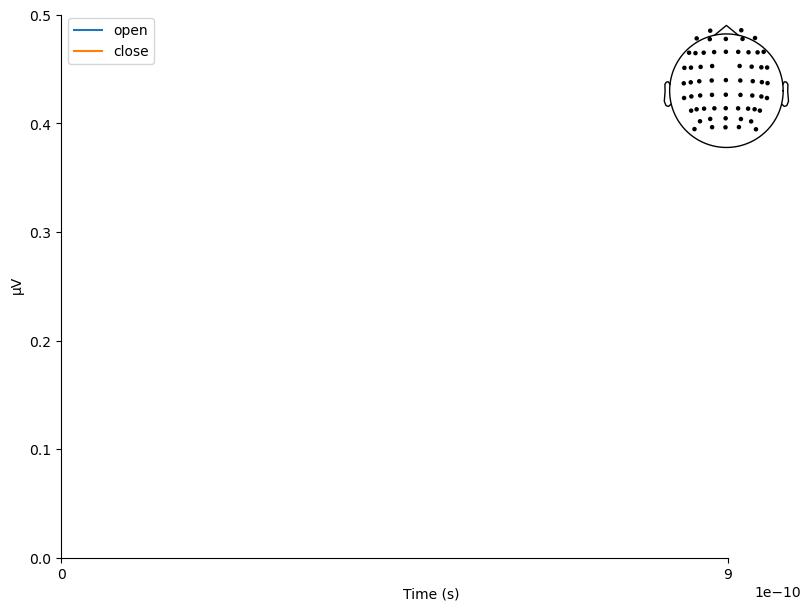

[<Figure size 800x600 with 2 Axes>]

In [129]:
oe_evoked = oe_epochs.average()
ce_evoked = ce_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(open=oe_evoked, close=ce_evoked),
    legend="upper left",
    show_sensors="upper right",
)

C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\topo.py:396: RuntimeWarning: divide by zero encountered in scalar divide
  bn.x_s = pos[2] / (xlim[1] - xlim[0])
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\topo.py:397: RuntimeWarning: invalid value encountered in scalar multiply
  bn.x_t = pos[0] - bn.x_s * xlim[0]
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\topo.py:674: RuntimeWarning: invalid value encountered in multiply
  bn.x_t + bn.x_s * times_,
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\topo.py:683: RuntimeWarning: invalid value encountered in multiply
  vline = np.array(vline) * bn.x_s + bn.x_t


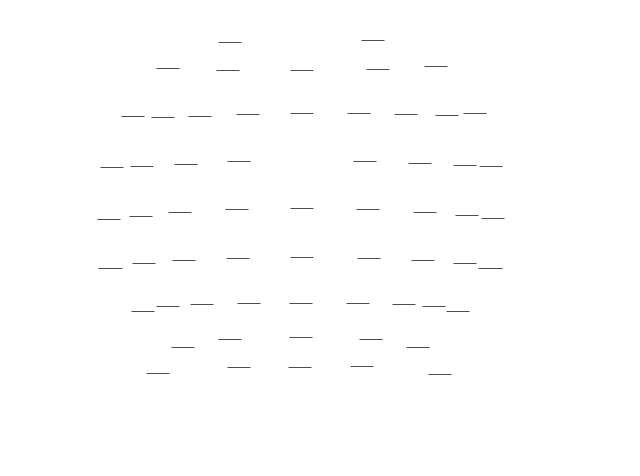

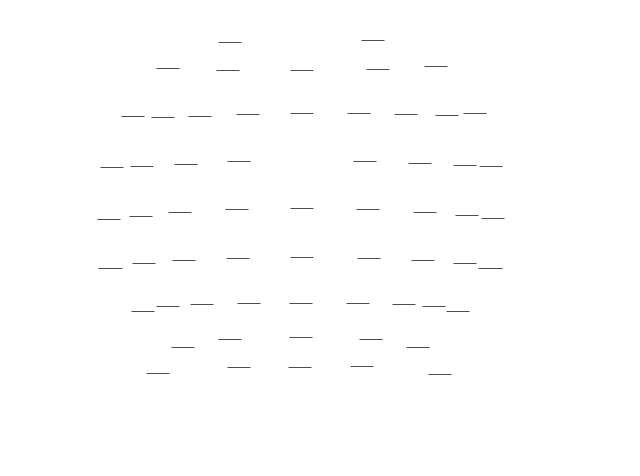

In [130]:
evoked_diff = mne.combine_evoked([oe_evoked, ce_evoked], weights=[1, -1])
evoked_diff.pick(picks="eeg").plot_topo(color="r", legend=False)

Using data from preloaded Raw for 240 events and 1 original time points ...
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\epochs.py:609: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax_im.imshow(


combining channels using "gfp"


C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\utils.py:1924: RuntimeWarning: divide by zero encountered in log10
  exp = np.log10(np.abs(tval))
C:\Users\enriq\anaconda1\Lib\site-packages\mne\viz\epochs.py:646: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax["evoked"].set_xlim(tmin, tmax)


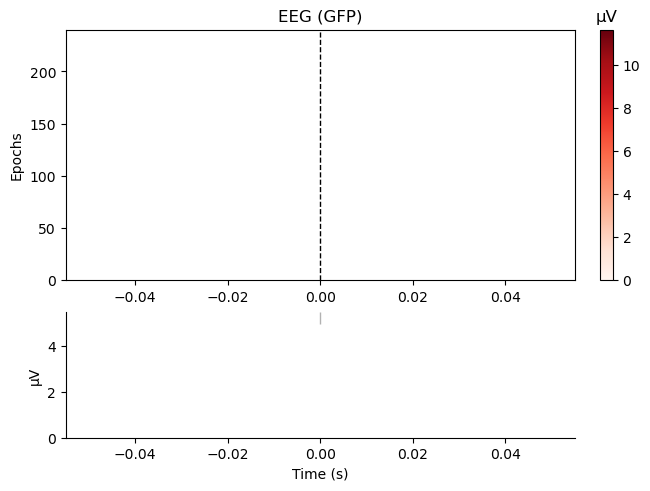

[<Figure size 640x480 with 3 Axes>]

In [132]:
oe_epochs.plot_image()

In [133]:
catch_trials_and_buttonpresses = mne.pick_events(events)
epochs["210"].plot(
    events=events,
    event_id=event_dict,
    #event_color=dict(button=1, face="blue"),
)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
eog_projs, _ = compute_proj_eog(eeg, n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=True)